In [1]:
#TODO: Insert train/validation loss plot + EM/F1 scores for original reformulator

#TODO: Insert train/validation loss plot + EM/F1 scores for filtered reformulator

#TODO: get count of dataset, get count of filtered dataset

In [ ]:
!pip install transformers datasets
!pip install sentencepiece

In [150]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
filtered_vali = [1.001426, 0.964072, 0.943505, 0.928900, 0.923954, 0.913895, 0.910533, 0.907546,0.907201]
filtered_train = [1.486300, 1.372500, 1.334900, 1.313200, 1.294600, 1.285800, 1.276900, 1.271200, 1.264500]
labels = [100, 200, 300, 400, 500, 600, 700, 800, 900]
x = [0,1,2,3,4,5,6,7,8]

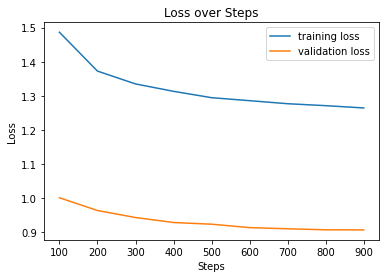

In [24]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(filtered_train)
plt.plot(filtered_vali)
plt.legend(['training loss', 'validation loss'])
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss over Steps')
plt.xticks(x, labels)  # Set label locations.
plt.show()

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import pandas as pd
train_mqr_df = pd.read_csv('drive/MyDrive/t5-data/download/train_mqr_with_category.tsv', sep='\t')
test_mqr_df = pd.read_csv('drive/MyDrive/t5-data/download/test_mqr_with_category.tsv', sep='\t')



In [28]:
print(train_mqr_df.count())
print(test_mqr_df.count())

ill formed     423494
well formed    423494
category       423494
dtype: int64
ill formed     2113
well formed    2113
category       2113
dtype: int64


In [ ]:
for i in range(20):
  print("Ill formed: ", train_mqr_df['ill formed'][i])
  print("Well formed: ", train_mqr_df['well formed'][i])

In [29]:
train_mqr_df_filtered = pd.read_csv('drive/MyDrive/t5-data/download/mqr_with_category_train_filtered.csv')
train_mqr_df_filtered.count()

Unnamed: 0     96286
ill formed     96286
well formed    96286
category       96286
make           96286
dtype: int64

In [ ]:
for i in range(20):
  print("Ill formed: ", train_mqr_df_filtered['ill formed'][i])
  print("Well formed: ", train_mqr_df_filtered['well formed'][i])

In [62]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, DataCollator, T5ForConditionalGeneration, T5TokenizerFast
model = T5ForConditionalGeneration.from_pretrained('drive/MyDrive/t5-results/saved/checkpoint-3900')
tokenizer = T5TokenizerFast.from_pretrained('t5-small')

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

In [49]:
##inference
import json
with open('drive/MyDrive/t5-data/download/sample_questions.json','r') as file:
  sample_questions = json.load(file)

def hf_run_model(input_string, category, **generator_args):
  generator_args = {
  "max_length": 256,
  "num_beams": 4,
  "length_penalty": 1.5,
  "no_repeat_ngram_size": 3,
  "early_stopping": True,
  }
  input_string = "generate question: " + category + input_string + " </s>"
  input_ids = tokenizer.encode(input_string, return_tensors="pt")
  res = model.generate(input_ids.to(device), **generator_args)
  output = tokenizer.batch_decode(res, skip_special_tokens=True)
  output = [item.split("<sep>") for item in output]
  return output


for sam in sample_questions:
  question, category = sam['question'], sam['category']
  pred = hf_run_model(question, category)
  sam['predicted_question'] = pred

KeyboardInterrupt: ignored

In [50]:
sample_questions[0:10]


[{'category': 'COMMON BONDS',
  'air_date': '1998-09-07',
  'question': "'A game of footsie,<br />a bribe,<br />a drunk person'",
  'value': '$500',
  'answer': 'Things that are done under the table',
  'round': 'Jeopardy!',
  'show_number': '3216',
  'predicted_question': [['question: What is the difference between a game of footsie,br />a bribe and a drunk person?']]},
 {'category': 'CONGRESSIONAL MISDEMEANORS',
  'air_date': '2005-06-29',
  'question': "'Senator Benjamin Tappan was censured in 1844 for leaking information about the annexation of this to the Union'",
  'value': '$2000',
  'answer': 'Texas',
  'round': 'Double Jeopardy!',
  'show_number': '4808',
  'predicted_question': [['question: Why was Benjamin Tappan censured in 1844 for leaking information about the annexation of this to the Union?']]},
 {'category': 'THE CHAIN GANG',
  'air_date': '1998-05-22',
  'question': '\'In any of this chain of theme parks, like the one "Over Texas", you might run into Looney Tunes char

In [51]:
def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)

In [56]:
dev_mqr_df = pd.read_csv('drive/MyDrive/t5-data/download/dev_mqr_with_category.tsv', sep='\t')
dev_count = len(dev_mqr_df)


In [ ]:
!pip install nltk

In [97]:
em_scores = []
f1_scores = []
import nltk
from nltk.translate import bleu
from nltk import bleu_score

all_bleu = []

for i in range(dev_count):
  question, category = dev_mqr_df['ill formed'][i], dev_mqr_df['category'][i]
  gt = [dev_mqr_df['well formed'][i].split()]
  pred = hf_run_model(question, category)[0][0][9:].split()
  

  score = bleu_score.sentence_bleu(gt, pred)
  all_bleu.append(score)




/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [100]:
print(sum(all_bleu)/len(all_bleu) * 100) 

13.976663426215833


In [122]:
dev_mqr_df = pd.read_csv('drive/MyDrive/t5-data/download/dev_mqr_with_category.tsv', sep='\t')

dev_mqr_df['make'] = dev_mqr_df['well formed'].str.split(' ').str[0]


In [123]:
qs = ['what', 'where', 'who', 'when', 'whose', 'which']
dev_mqr_df = dev_mqr_df[dev_mqr_df['make'].str.contains('What|Where|Who|When|Whose|Which', regex=True)]

In [124]:
dev_mqr_df = dev_mqr_df.drop('make', axis = 1)

In [125]:
for col in dev_mqr_df.columns:
    print(col)

ill formed
well formed
category


In [126]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, DataCollator, T5ForConditionalGeneration, T5TokenizerFast
model = T5ForConditionalGeneration.from_pretrained('drive/MyDrive/t5-results/checkpoint-900')
tokenizer = T5TokenizerFast.from_pretrained('t5-small')

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [146]:
all_bleu = []
count = len(dev_mqr_df)

for row in dev_mqr_df.iterrows():
  # print(row)
  question, category = row[1]['ill formed'], row[1]['category']
  gt = [row[1]['well formed'].split()]
  pred = hf_run_model(question, category)[0][0][9:].split()
  # print(pred, gt)
  

  score = bleu_score.sentence_bleu(gt, pred)
  # print(score)
  all_bleu.append(score)

print(sum(all_bleu)/len(all_bleu) * 100) 

/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


10.420572239751055


In [147]:
for sam in sample_questions:
  question, category = sam['question'], sam['category']
  pred = hf_run_model(question, category)
  sam['predicted_question'] = pred

KeyboardInterrupt: ignored

In [ ]:
sample_questions[0:10]

In [151]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-question-generation-ap")
model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-base-finetuned-question-generation-ap")

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Downloading:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

In [152]:
def get_question(answer, context, max_length=64):
  input_text = "answer: %s  context: %s </s>" % (answer, context)
  features = tokenizer([input_text], return_tensors='pt')

  output = model.generate(input_ids=features['input_ids'], 
               attention_mask=features['attention_mask'],
               max_length=max_length)

  return tokenizer.decode(output[0])

In [153]:
dev_mqr_df = pd.read_csv('drive/MyDrive/t5-data/download/dev_mqr_with_category.tsv', sep='\t')

In [161]:
all_bleu = []
count = len(dev_mqr_df)

for row in dev_mqr_df.iterrows():
  # print(row)
  question, category = row[1]['ill formed'], row[1]['category']
  gt = row[1]['well formed']
  pred = get_question(gt, question)

  gt = [normalize_text(gt).split()]
  pred = normalize_text(pred).split()[2:]


  #print(pred, gt)
  

  score = bleu_score.sentence_bleu(gt, pred)
  #print(score)
  all_bleu.append(score)



KeyboardInterrupt: ignored

In [162]:
print(sum(all_bleu)/len(all_bleu) * 100) 

24.054466411193204
